# Fabric tensor of trabecular bone - Mean Intercept Length (MIL)
Comparison with BoneJ/Anisotropy ImageJ plugin.

For a detailed explanation of the BoneJ plugin see: [https://bonej.org/anisotropy](https://bonej.org/anisotropy)

In [1]:
import os
import sys
# sys.path.insert(0, os.path.abspath('../'))
sys.path.append('/home/gianthk/PycharmProjects/recon_utils')
sys.path.append('/home/gianthk/PycharmProjects/pyfabric')

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pyfabric
import recon_utils as ru

astropy module not found
olefile module not found


In [3]:
print(np.__file__)

/home/gianthk/anaconda3/envs/CT2FE/lib/python3.8/site-packages/numpy/__init__.py


In [3]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

#### Read input data

In [4]:
# Trabecular bone scan
data_3D = ru.read_tiff_stack('/home/gianthk/Data/2019.001.coop_TUberlin_simulierte_Mensch.iorig/trabecular_samples/trabecular_sample_mini2/2000L_crop_imgaussfilt_60micron_uint8_0000.tif')

Inspect dataset

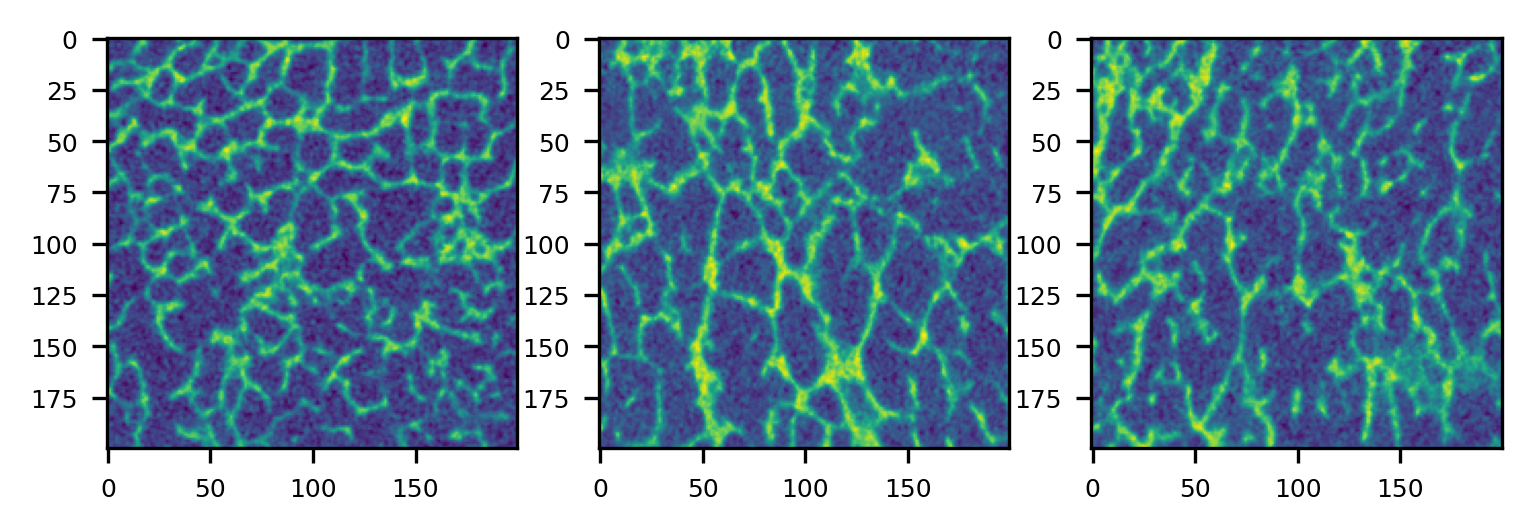

In [5]:
ru.plot_midplanes(data_3D)
plt.show()

## Pre-processing
### Gaussian smooth

In [5]:
from skimage.filters import threshold_otsu, gaussian

In [6]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Thresholding

In [7]:
# use Otsu's method
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 139.92754223554994


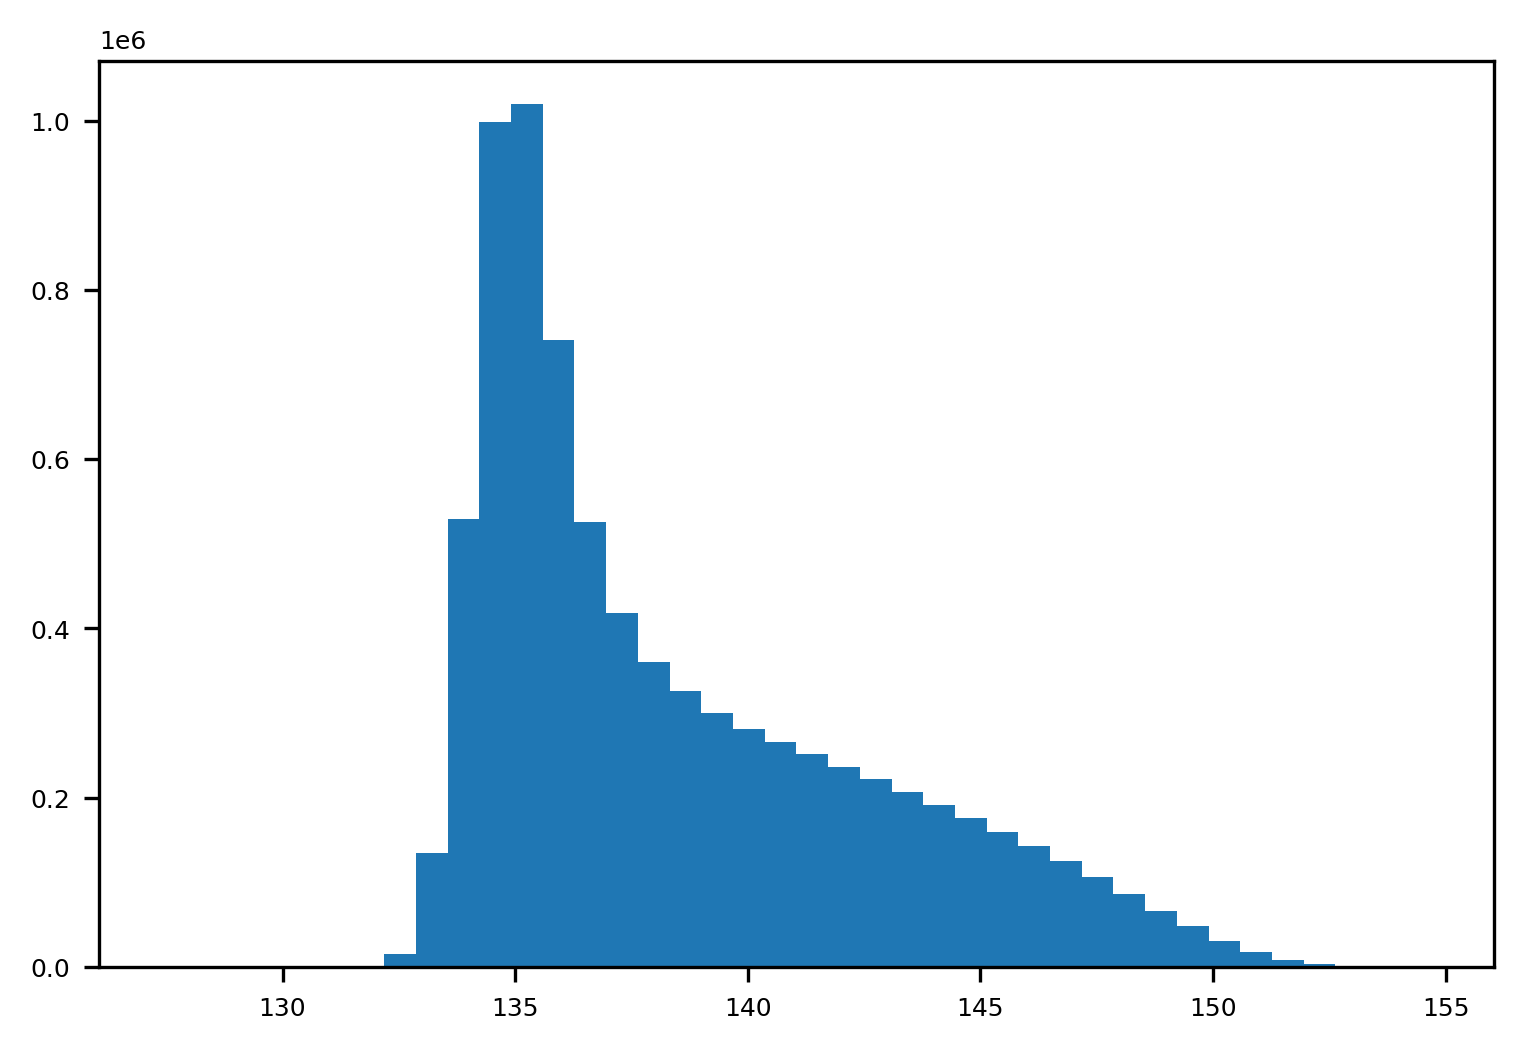

In [9]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

Apply single global threshold obtained from comparison with histology

In [8]:
BW = data_3D > T

Plot the binarized data

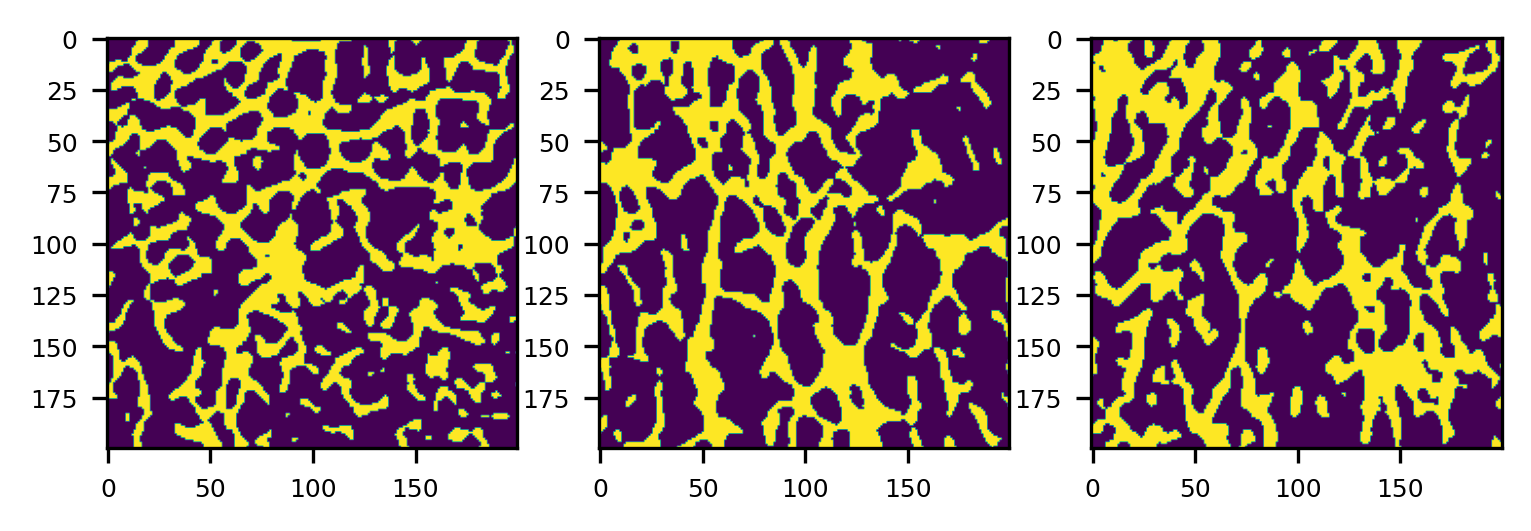

In [12]:
ru.plot_midplanes(BW)
plt.show()

### Detect edges

In [14]:
from skimage import measure, morphology

In [46]:
edges = (BW & ~morphology.binary_erosion(BW, morphology.ball(1))).astype('bool')

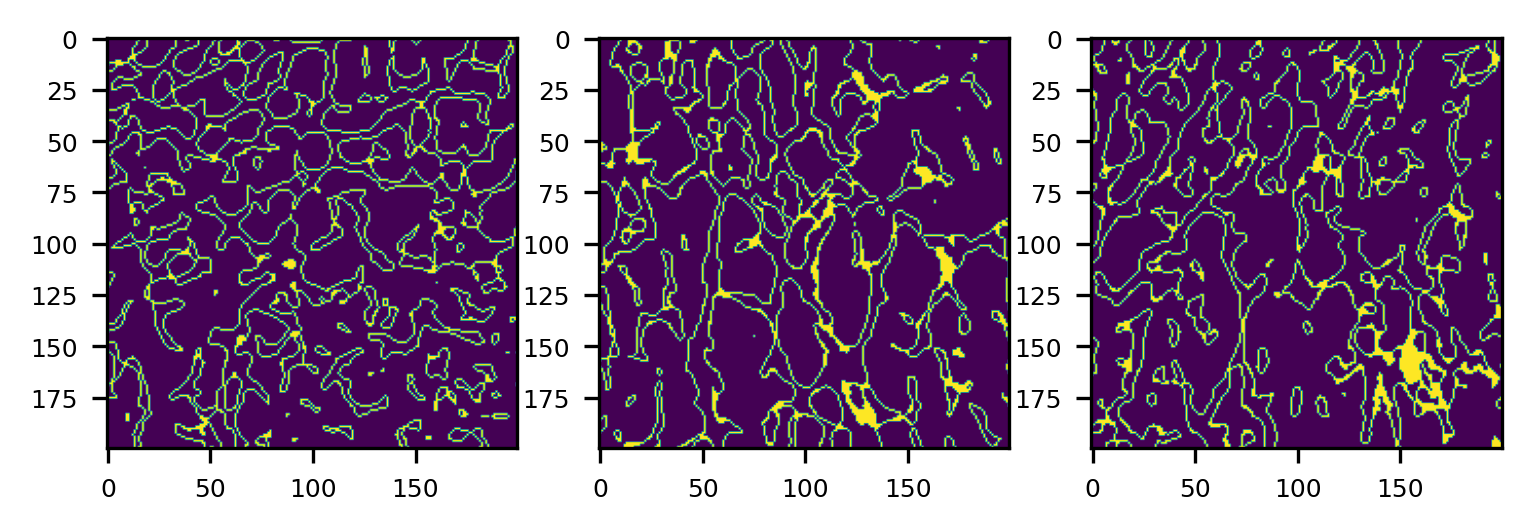

In [47]:
ru.plot_midplanes(edges)

In [51]:
import dxchange

In [52]:
dxchange.write_tiff_stack(edges,'pippo/slice_0000.tiff')

## Intercept lengths
Test on one X-Z slice

In [62]:
BW.shape

(200, 200, 200)

In [9]:
test_BW_2D = BW[:,100,:]
# plt.imshow(test_BW_2D)

### Create set of intercept lines

In [10]:
alpha = np.pi/3

In [348]:
offset = 400

In [349]:
xi = np.arange(0,test_BW_2D.shape[1],0.1)

In [350]:
yi = np.round(np.tan(alpha)*xi -offset).astype('int')

In [342]:
points_within_image = np.where(yi<test_BW_2D.shape[0])

In [327]:
yi[points_within_image]

array([  0,   0,   0, ..., 173, 173, 173])

In [351]:
points_within_image = (yi>=0) & (yi<test_BW_2D.shape[0]) 

In [352]:
A = np.zeros(test_BW_2D.shape).astype('bool')

In [353]:
np.round(xi).astype('int')

array([  0,   0,   0, ..., 200, 200, 200])

In [354]:
A[yi[points_within_image], xi[points_within_image].astype('int')]=1

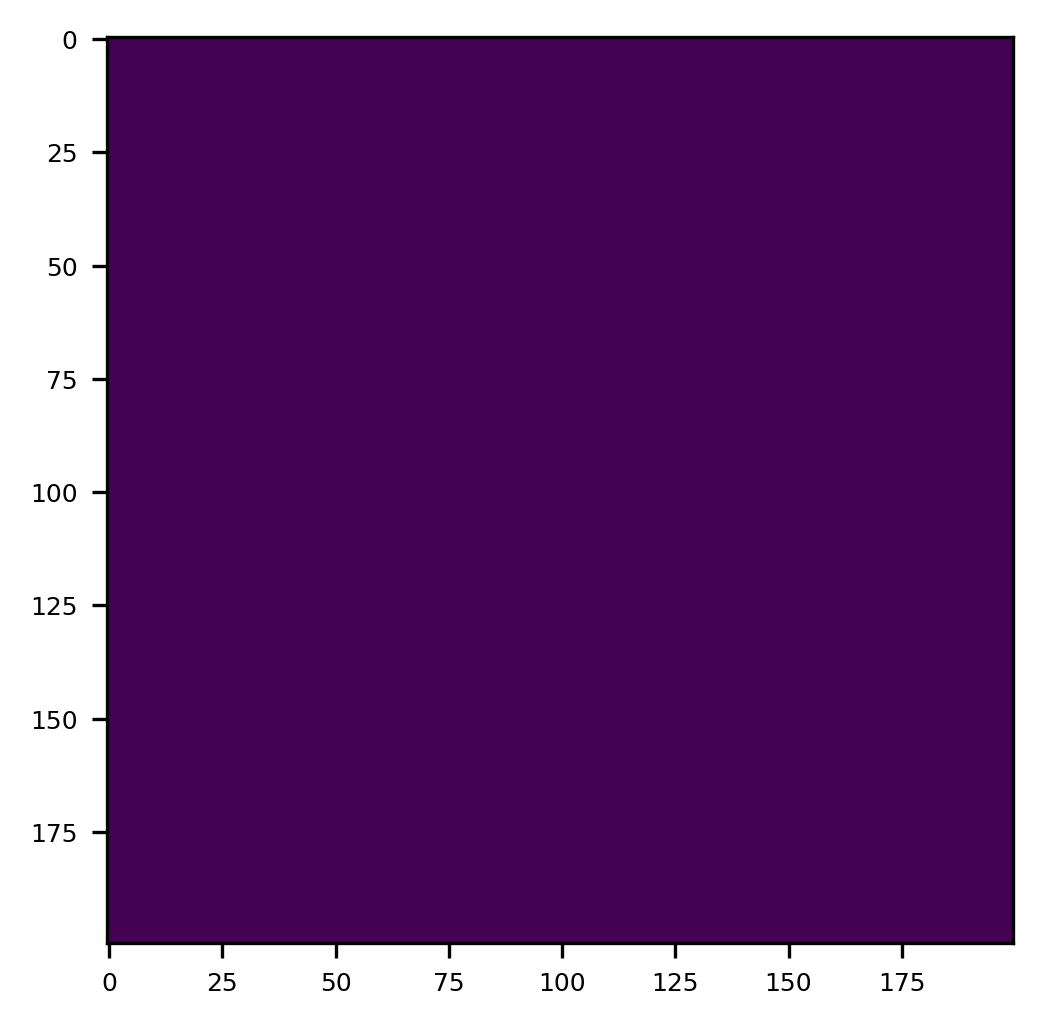

In [355]:
plt.imshow(A)

### Iterate and assemble intercept lines

In [143]:
for offset in range(-200,100,10):
    yi = np.round(np.tan(alpha)*xi + offset).astype('int')
    points_within_image = np.where(yi<test_BW_2D.shape[0])
    A[yi[points_within_image], xi[points_within_image]]=1

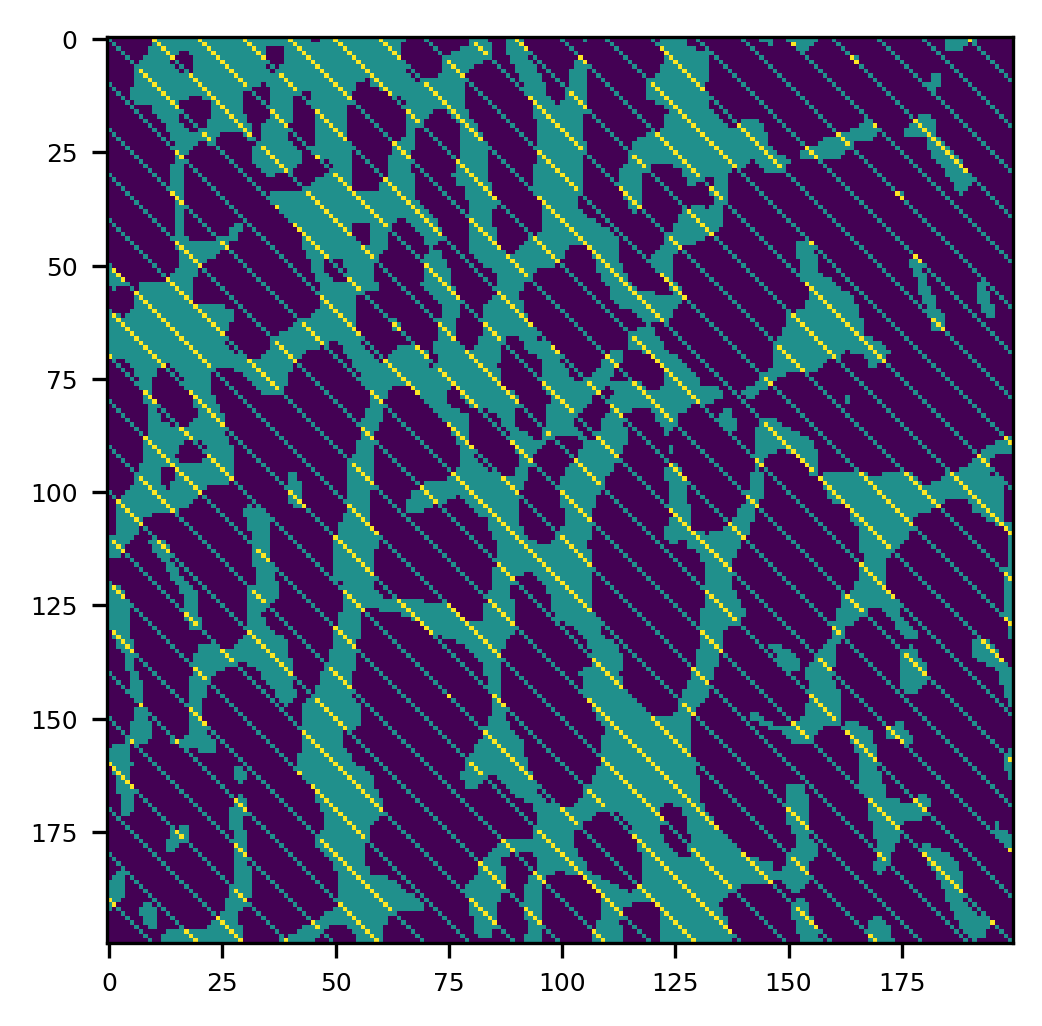

In [176]:
plt.imshow(A.astype('int') + test_BW_2D.astype('int'))

### Intercept binary image

In [147]:
intercept = A & test_BW_2D

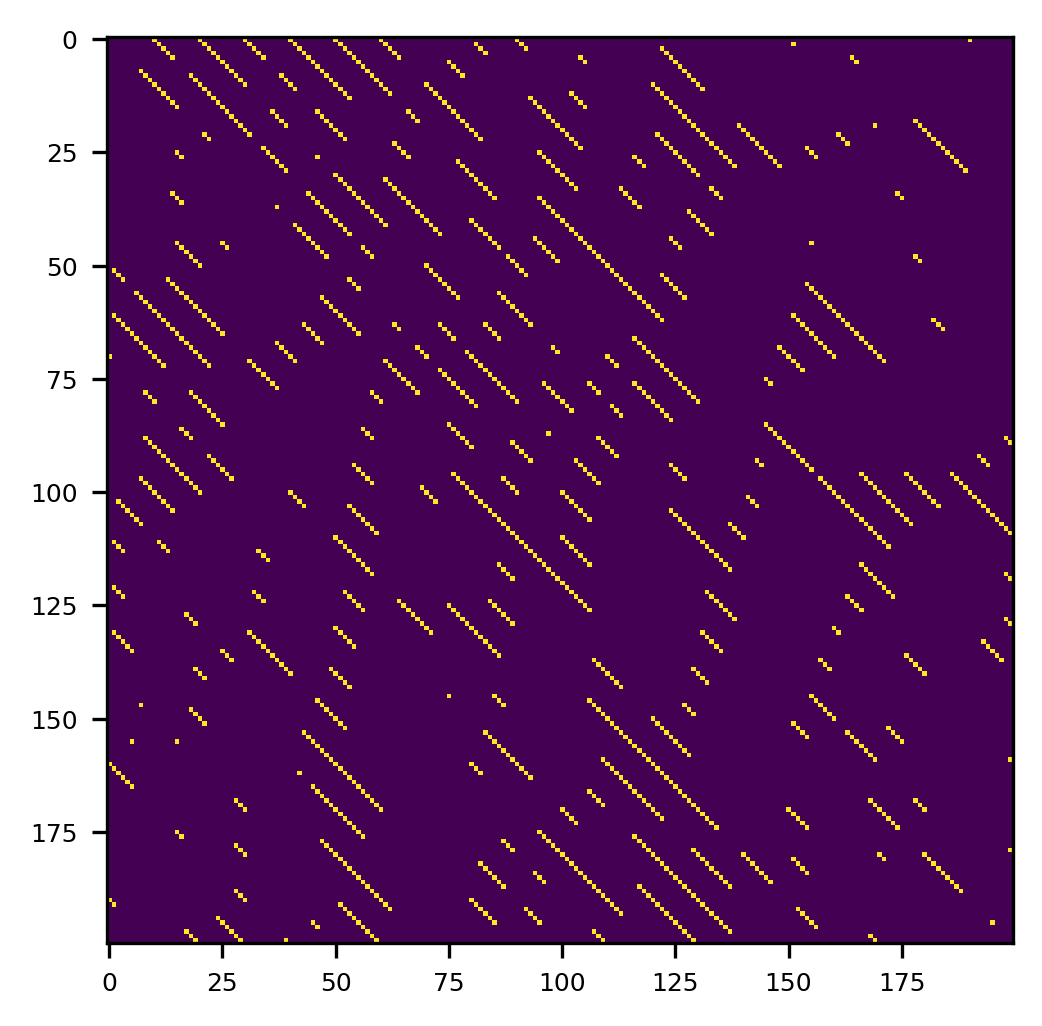

In [148]:
plt.imshow(intercept)

### Regionprops to detect intercept lengths

In [11]:
from skimage.measure import label, regionprops_table

In [157]:
intercepts = label(intercept)

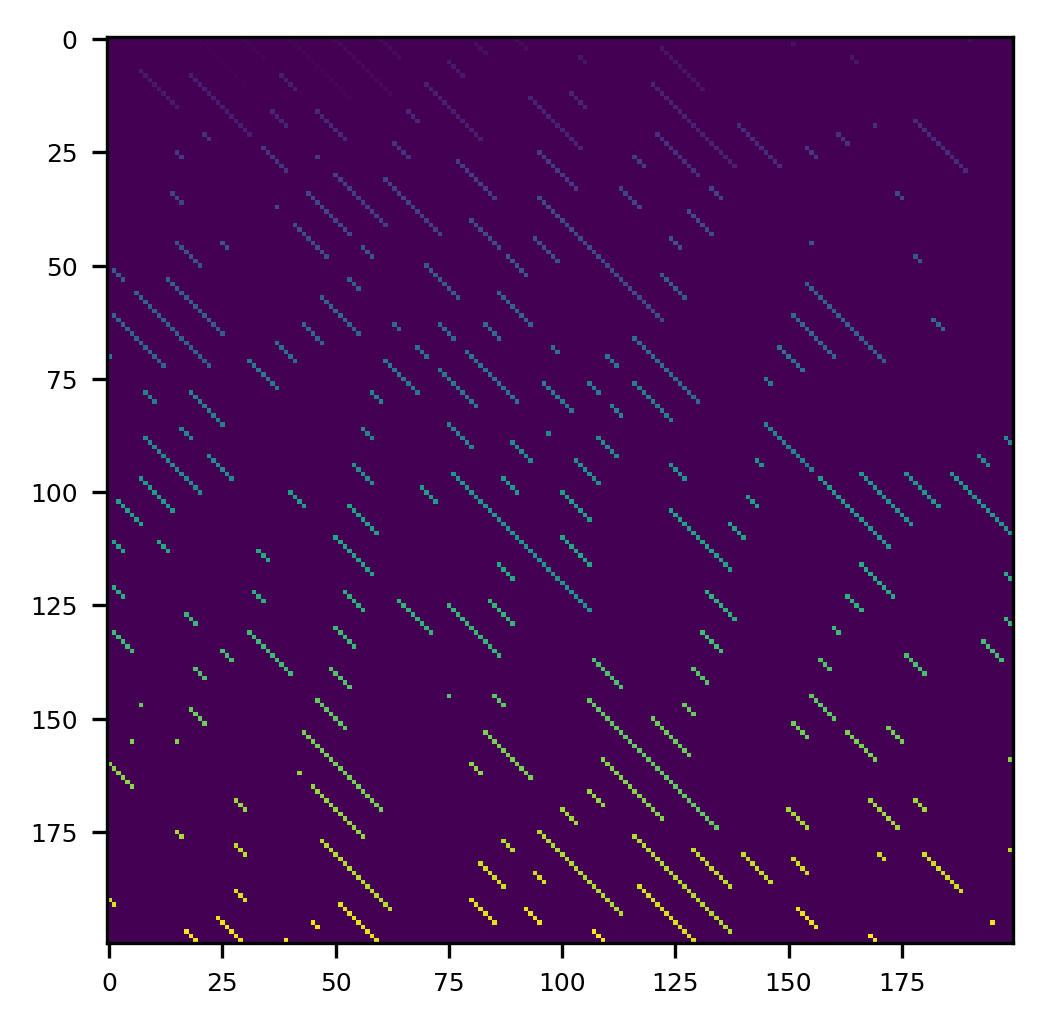

In [239]:
plt.imshow(intercepts)

In [162]:
# regions = regionprops(intercepts)

In [242]:
props = regionprops_table(intercepts, properties=['feret_diameter_max'])

In [243]:
intercept_lengths = props['feret_diameter_max']
print(intercept_lengths)

[ 6.40312424 14.86606875  6.40312424 19.10497317 17.69180601  6.40312424
  3.60555128  1.          3.60555128  1.         13.45362405  2.23606798
  2.23606798  5.         12.04159458 19.10497317  5.         17.69180601
 26.17250466  5.         16.2788206   5.          9.21954446  3.60555128
 16.2788206  13.45362405  1.          2.23606798 13.45362405  3.60555128
  5.          7.81024968  3.60555128  2.23606798 12.04159458  1.
  3.60555128 12.04159458 16.2788206  17.69180601  6.40312424  3.60555128
  3.60555128 13.45362405  2.23606798 38.89730068  1.          7.81024968
  9.21954446 10.63014581  7.81024968  3.60555128  7.81024968  2.23606798
  1.          3.60555128  6.40312424  2.23606798 10.63014581  3.60555128
  7.81024968 17.69180601  3.60555128 24.75883681 23.34523506 10.63014581
 12.04159458 16.2788206  13.45362405  3.60555128  6.40312424  2.23606798
  5.          5.         20.51828453  6.40312424  3.60555128  2.23606798
  7.81024968 16.2788206   1.          3.60555128  9.2195444

In [244]:
MIL = np.mean(props['feret_diameter_max'])

In [245]:
MIL

8.194970979973633

## Put everything into a function

In [91]:
def MIL2D_alpha_0(I, alpha, spacing, verbose=False):
    # for angles around 0
    yi, xi = I.shape
    x = np.arange(0,xi,1)
    slope = np.tan(alpha)
    cos_alpha = np.cos(alpha)
    
    
    # create intercept lines image
    A = np.zeros(I.shape).astype('bool')
    
    for offset in range(-xi,xi,spacing):
        y = np.round(slope*x + offset/cos_alpha).astype('int')
        points_within_image = (y>=0) & (y<yi) 
        A[y[points_within_image], np.floor(x[points_within_image]).astype('int')]=True
    
    # if verbose:
        # plt.imshow(A.astype('int') + I.astype('int'))
        
    # intercept the input binary image
    intercept = A & I
    
    # label and get intercept lengths
    intercepts = label(intercept)
    if verbose:
        plt.imshow(intercepts-10*I)
        # plt.imshow(A)
    
    props = regionprops_table(intercepts, properties=['feret_diameter_max'])
    
    return np.mean(props['feret_diameter_max'])

In [92]:
def MIL2D_alpha_pi2(I, alpha, spacing, verbose=False):
    # for angles around pi/2
    yi, xi = I.shape
    y = np.arange(0,yi,1)
    slope = np.tan(alpha)
    cos_alpha = np.cos(alpha)
    
    
    # create intercept lines image
    A = np.zeros(I.shape).astype('bool')
    
    for offset in range(-yi,yi,spacing):
        x = np.round((y-(offset/cos_alpha))/slope).astype('int')
        points_within_image = (x>=0) & (x<xi) 
        A[np.floor(y[points_within_image]).astype('int'), x[points_within_image]]=True
    
    # if verbose:
        # plt.imshow(A.astype('int') + I.astype('int'))
        
    # intercept the input binary image
    intercept = A & I
    
    # label and get intercept lengths
    intercepts = label(intercept)
    if verbose:
        plt.imshow(intercepts-10*I)
        # plt.imshow(A)
    
    props = regionprops_table(intercepts, properties=['feret_diameter_max'])
    
    return np.mean(props['feret_diameter_max'])

7.768576260258047


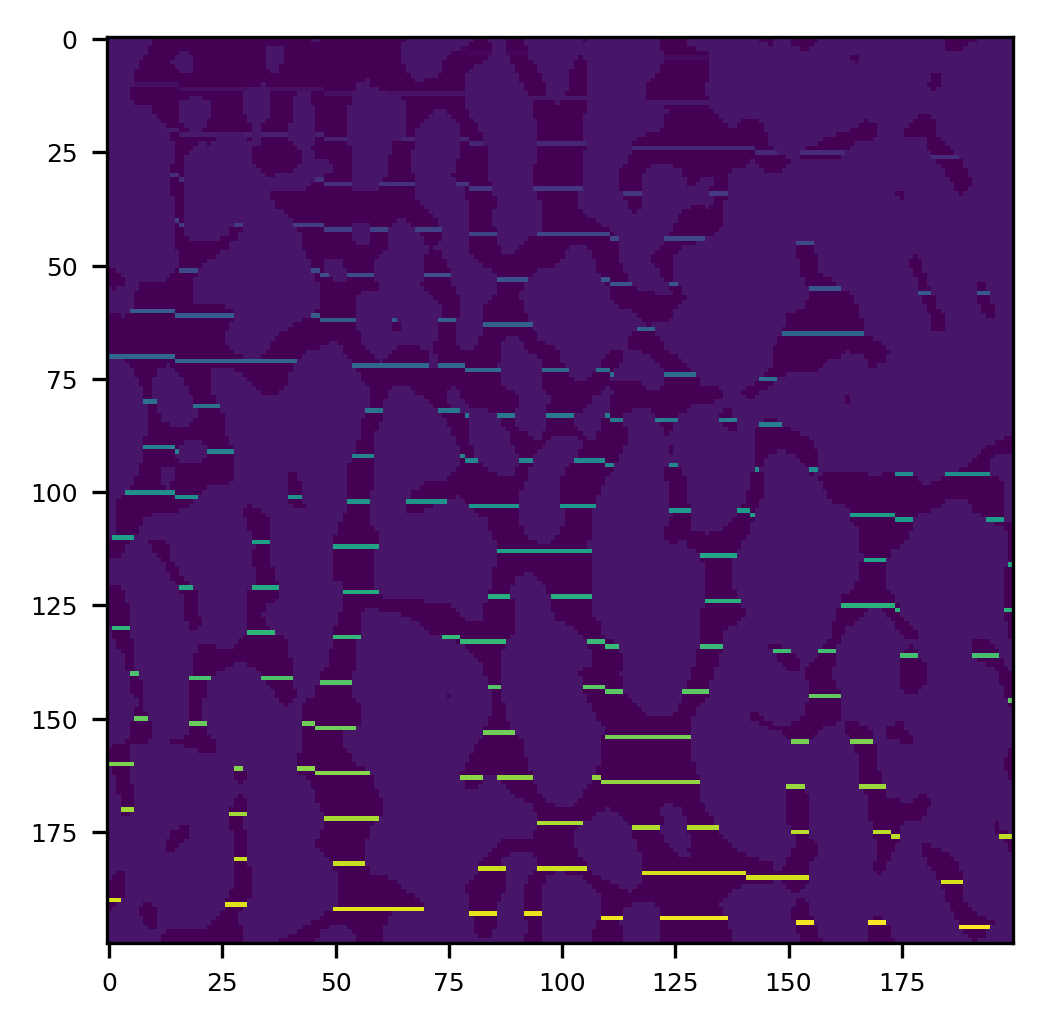

In [93]:
print(MIL2D_alpha_0(test_BW_2D, 0.01*np.pi, 10, True))

9.487232501785948


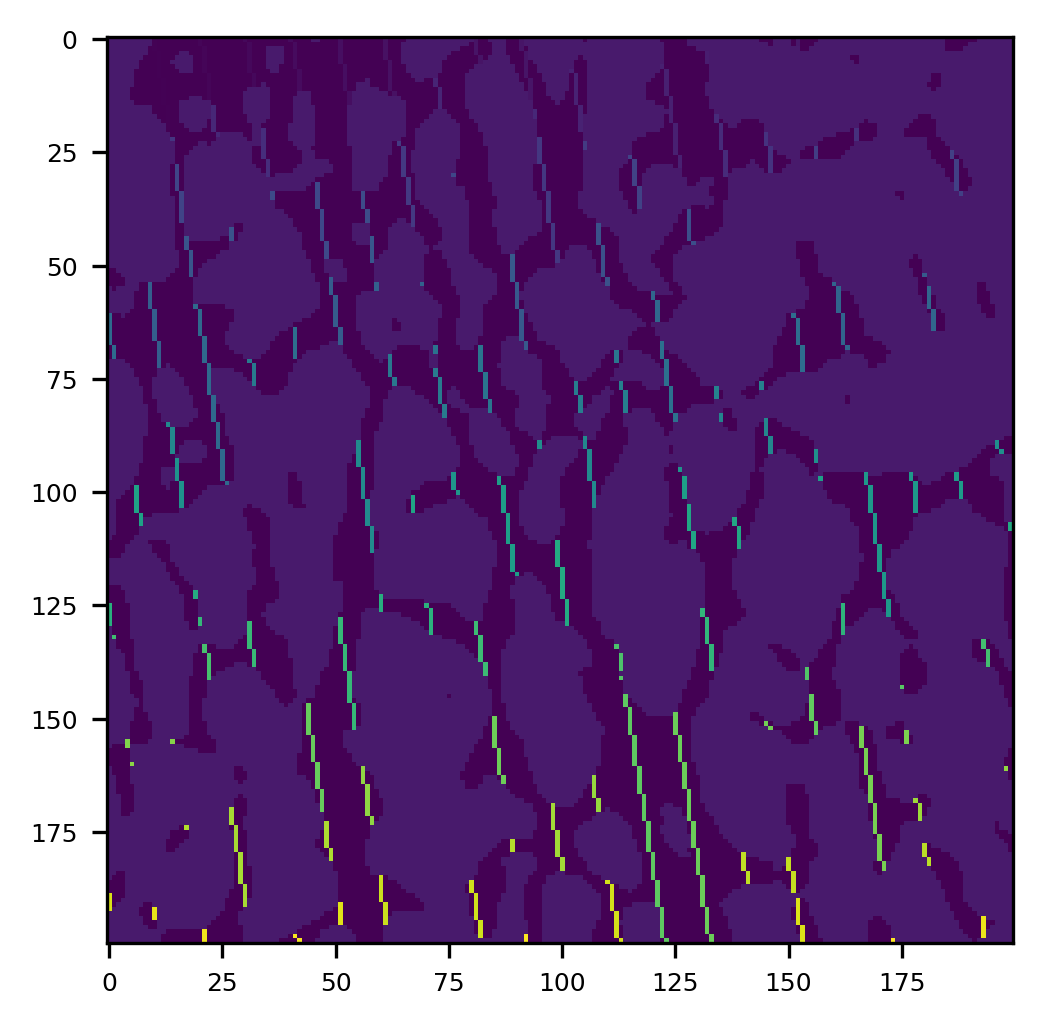

In [64]:
print(MIL2D_alpha_pi2(test_BW_2D, 0.45*np.pi, 10, True))

### Iterate over 180 degree

In [135]:
alpha_spacing = np.pi/60

In [129]:
spacing = 5

In [136]:
alpha = np.arange(-np.pi/4,3*np.pi/4,alpha_spacing)

In [137]:
MIL = np.zeros(alpha.shape)

In [138]:
for a in np.where(alpha<np.pi/4)[0]:
    MIL[a] = MIL2D_alpha_0(test_BW_2D, alpha[a], spacing)
for a in np.where(alpha>=np.pi/4)[0]:
    MIL[a] = MIL2D_alpha_pi2(test_BW_2D, alpha[a], spacing)

In [139]:
MIL

array([ 8.34871647,  8.26915478,  7.79592454,  7.84958323,  7.69293236,
        7.47520453,  7.58889395,  7.57103139,  7.63747166,  7.2680639 ,
        7.6931281 ,  7.47976334,  7.37158084,  7.52774178,  7.60097066,
        7.91097923,  7.59979719,  7.61612278,  7.46638834,  7.5308588 ,
        7.60800842,  7.64983707,  7.51710142,  7.72625426,  7.4966534 ,
        7.69283595,  7.75646484,  8.17734518,  8.03576461,  8.37572126,
        8.21547033,  8.25568837,  8.50737707,  8.79037188,  8.67583313,
        8.94505959,  8.81537532,  9.408996  ,  9.28442588,  9.39265174,
        9.68216955, 10.16161351, 10.36081188, 10.5491411 , 11.00425992,
       10.76422764, 10.49538926, 11.03654014,  9.88259163, 10.25910722,
        9.6724978 ,  9.27789553,  9.35981286,  8.99788132,  8.66349695,
        9.1030765 ,  8.51597477,  8.87258437,  8.48311934,  8.28633866])

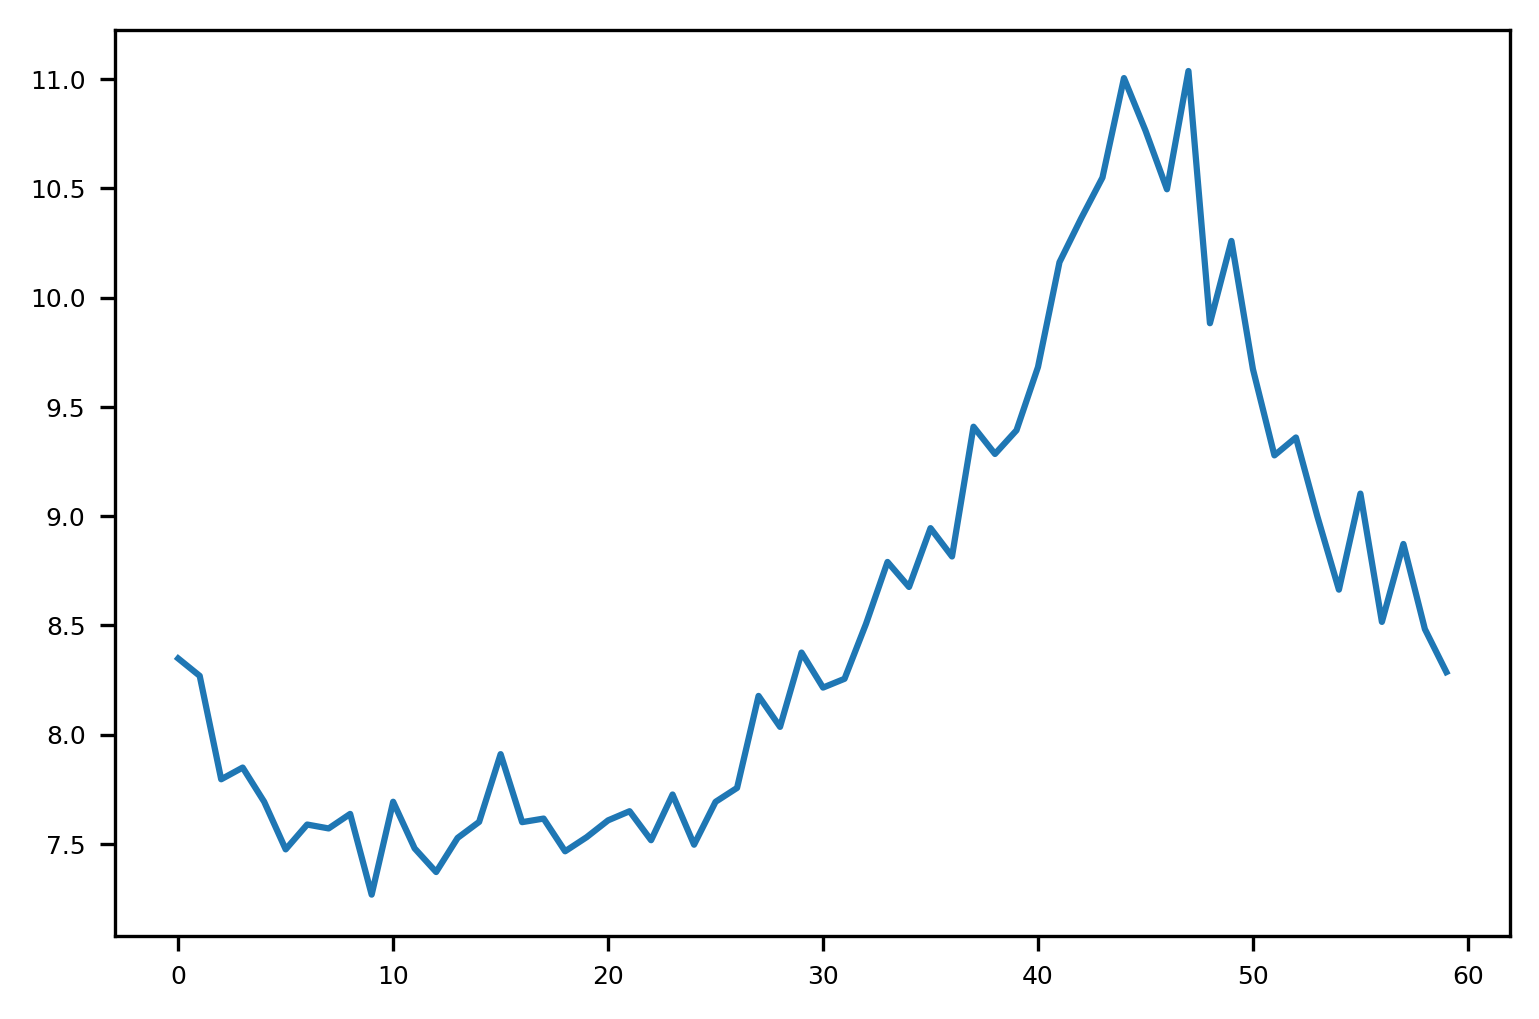

In [140]:
plt.plot(MIL)

# 3D image rotation around the Z-axis
This is needed to calculate the 2D MIL along different Yaw orientation of the image

1. with `scipy`
- https://splunktool.com/3d-image-rotation-in-python
uses:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.rotate.html#scipy.ndimage.rotate

2. with `skimage`
- https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.rotate

3. with `NVIDIA DALI`
- https://docs.nvidia.com/deeplearning/dali/user-guide/docs/examples/image_processing/3d_transforms.html


In [187]:
int(np.ceil(xi/2))

100

In [44]:
2/4-1/3

0.16666666666666669

In [ ]:
1/4+()

In [ ]:
aaaa

In [60]:
np.tan(np.pi/5)

0.7265425280053609

In [48]:
print(np.max(edges))

True


### Compute fabric information with pyfabric

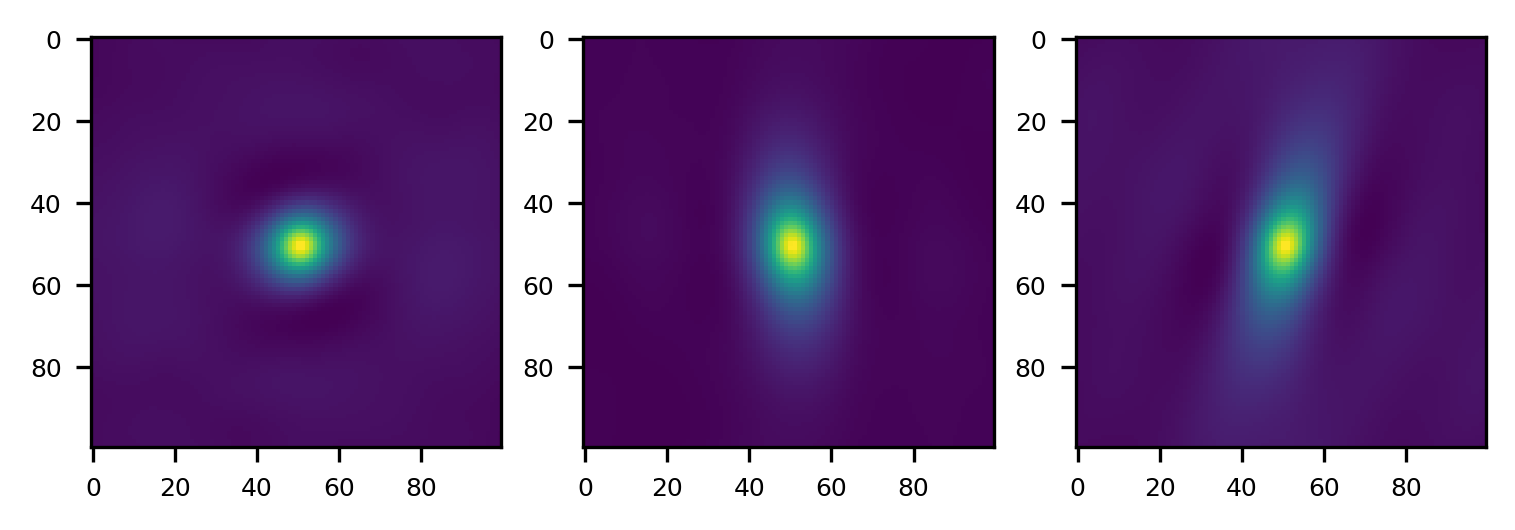

In [27]:
evecs, radii, evals, fabric_comp, DA = pyfabric.fabric(data_3D, zoom=True, zoom_factor=2, zoom_size=data_3D.shape[0]/4, ACFplot=True)

In [25]:
radii

array([ 8.32373606,  9.82361518, 14.97799331])

### Read results table from BoneJ

In [13]:
import pandas as pd

In [14]:
df = pd.read_csv('/home/gianthk/Data/2019.001.coop_TUberlin_simulierte_Mensch.iorig/trabecular_samples_bin/bonej_results.csv')

In [15]:
df.head()

,\,DA,Radius a,Radius b,Radius c,m00,m01,m02,m10,m11,m12,m20,m21,m22,D1,D2,D3
0,trabecular_sample_mini,0.550305,9.667777,10.830403,14.416763,-0.367184,-0.864930,-0.342158,0.926136,-0.305835,-0.220766,-0.086303,0.397946,-0.913340,0.004811,0.008525,0.010699
1,trabecular_sample_mini2,0.495877,10.571103,10.990377,14.888535,0.395505,0.899910,0.183680,0.907785,-0.352603,-0.227150,0.139648,-0.256581,0.956381,0.004511,0.008279,0.008949
2,trabecular_sample_mini3,0.533950,10.701554,11.116879,15.675837,-0.732929,-0.680283,0.005400,0.643813,-0.696158,-0.317599,0.219816,-0.229301,0.948210,0.004069,0.008092,0.008732


In [16]:
df['Radius a'][1]

10.571103049208778

In [17]:
radii_bj = df.iloc[1,2:5].to_numpy()

In [18]:
evecs_bj = np.reshape(df.iloc[1,5:14].tolist(), (3,3))

In [29]:
radii/np.max(radii)

array([1.        , 0.60654695, 0.5457588 ])

In [30]:
radii_bj/np.max(radii_bj)

array([0.7100163512979913, 0.7381772309268224, 1.0], dtype=object)

### Plot results

In [20]:
import ellipsoid_fit as ef

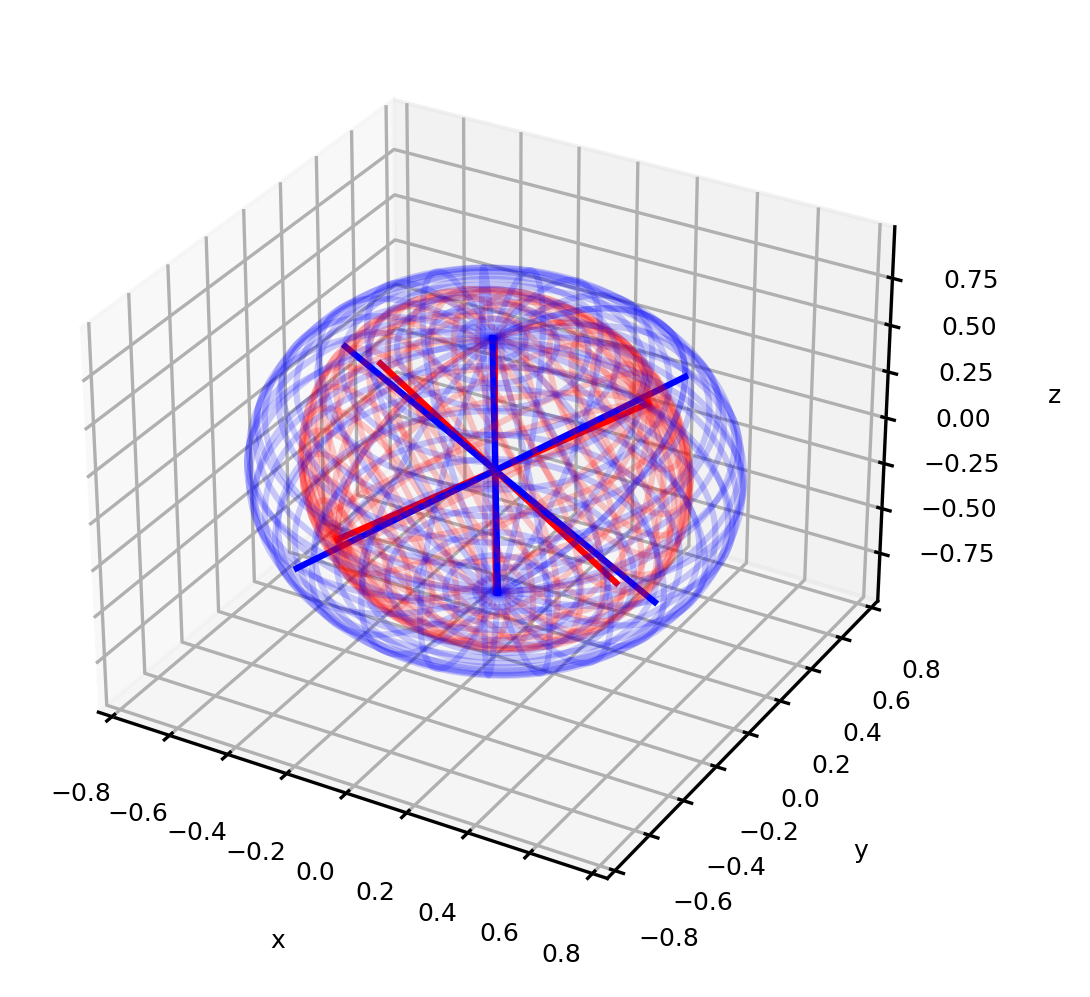

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(coors[:,0], coors[:,1], coors[:,2], zdir='z', s=0.4, c='b',rasterized=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ef.ellipsoid_plot([0, 0, 0], radii/np.max(radii), evecs, ax=ax, plot_axes=True, cage_color='red')
ef.ellipsoid_plot([0, 0, 0], radii_bj/np.max(radii_bj), evecs_bj, ax=ax, plot_axes=True, cage_color='blue')
plt.show()

Compute $ACF = |Ev^{-1}(Ev(ROI) conj(Ev(ROI)))|$

In [10]:
ACF = np.abs(np.fft.ifftshift(np.fft.ifftn(Ev * np.conj(Ev))))

Inspect the ACF

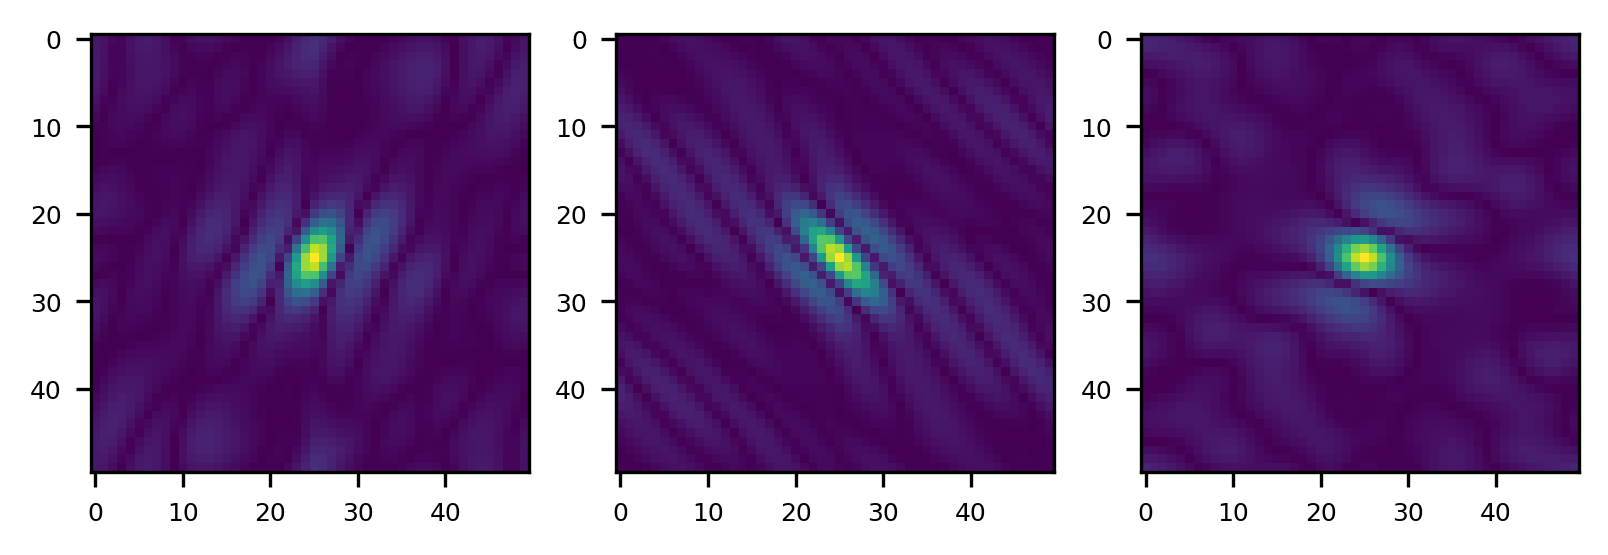

In [11]:
plot_midplanes(ACF)
plt.show()

#### Zoom ACF center
Let's take half of the ACF image along each direction and zoom it with factor 2

In [12]:
from scipy import ndimage

In [13]:
zoom_factor = 2
center = ACF.shape
size = round(min(center)/4)
center = [int(center[0]/2), int(center[1]/2), int(center[2]/2)]

In [14]:
ACFzoom = ndimage.zoom(ACF[center[0]-size:center[0]+size, center[1]-size:center[1]+size, center[2]-size:center[2]+size], zoom_factor, output=None, order=2)

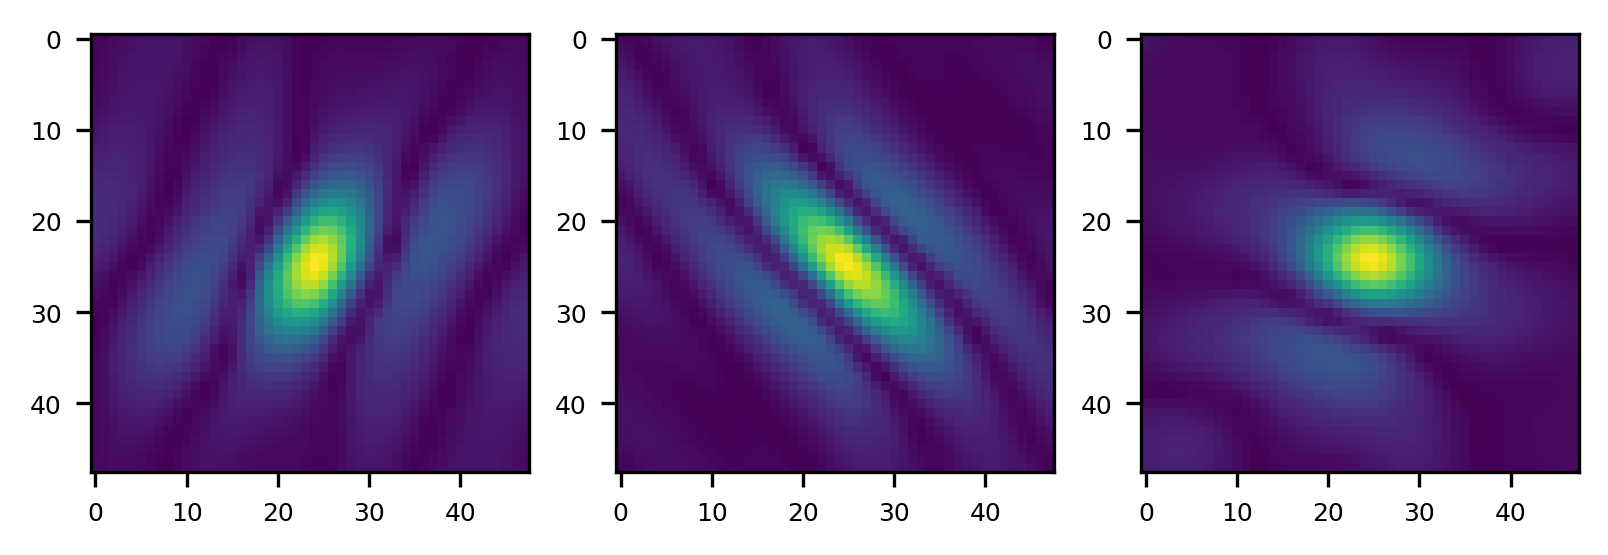

In [15]:
plot_midplanes(ACFzoom)
plt.show()

#### Normalize to 0-1 range

In [16]:
ACFmin = np.min(ACFzoom)
ACFmax = np.max(ACFzoom)
df = ACFmax - ACFmin

In [17]:
ACFnorm = (ACFzoom-ACFmin)/df

Segment the normalized ACF

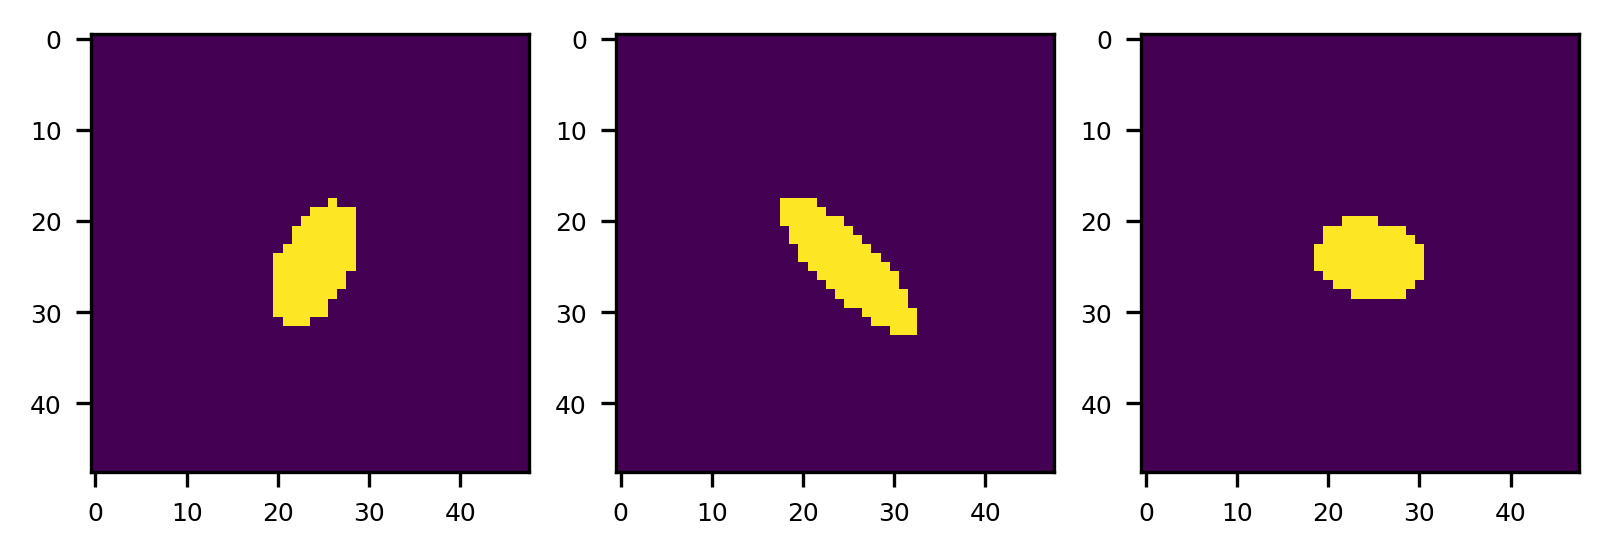

In [18]:
plot_midplanes(ACFnorm>0.5)
plt.show()

#### Extract envelope points on ellipsoid

In [19]:
from skimage.measure import marching_cubes

In [20]:
# coors, triangles, tmp, tmp2 = marching_cubes(np.transpose(ACFnorm>0.5, [2, 1, 0]), level=None, step_size=1)
coors, triangles, tmp, tmp2 = marching_cubes(ACFnorm>0.5, level=None, step_size=1)

Scatter plot of the envelope points

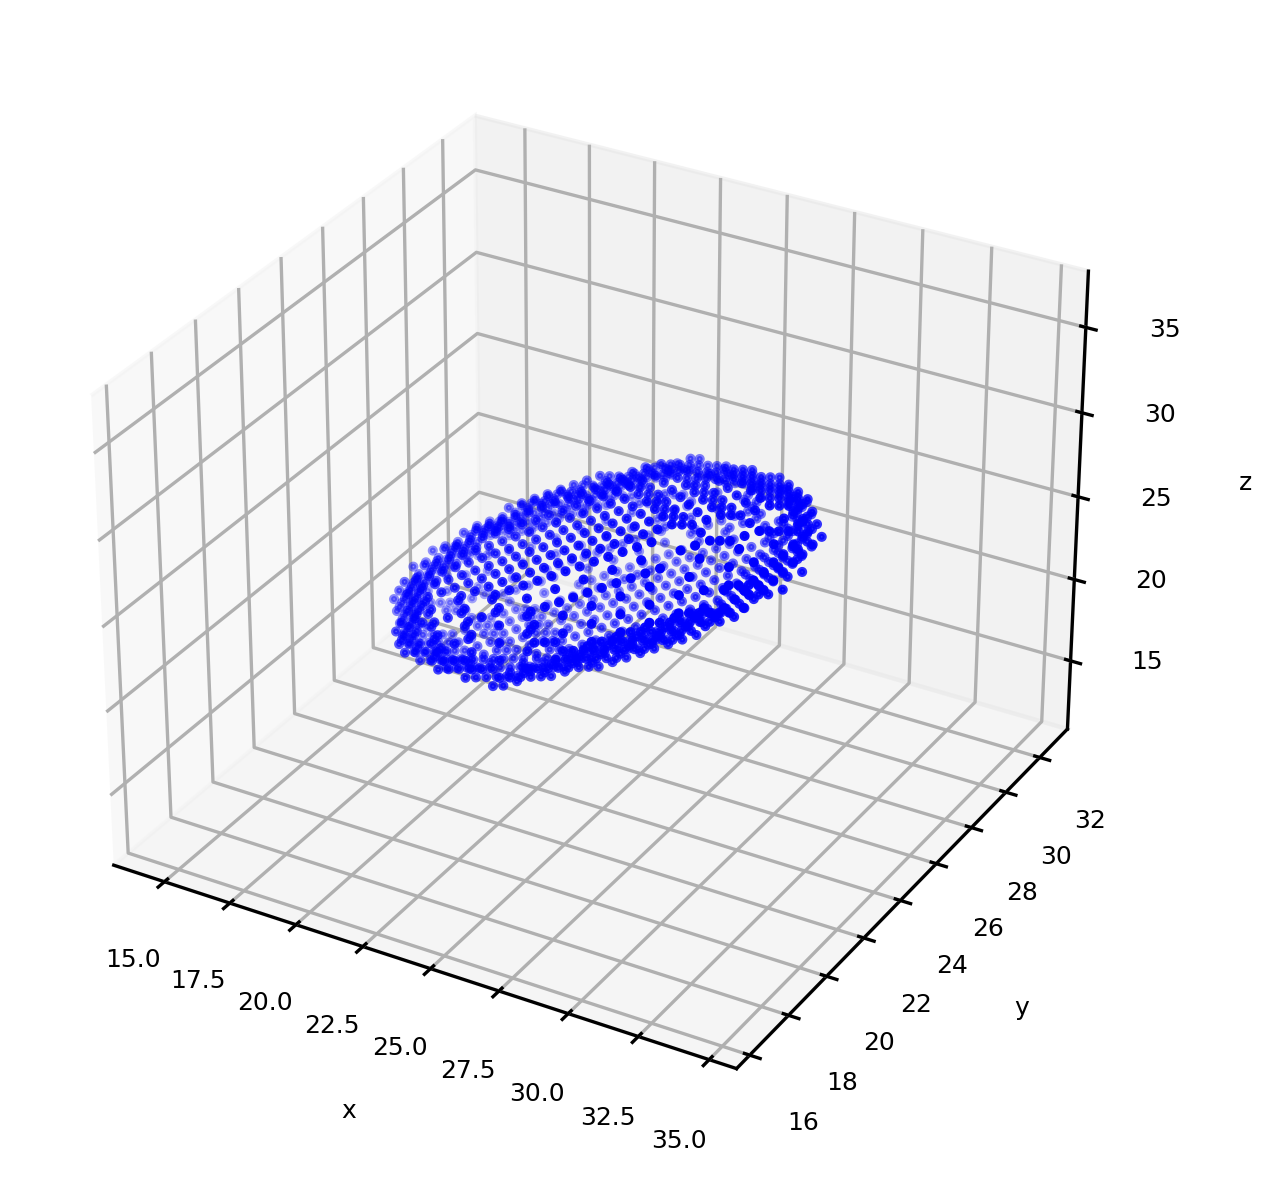

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coors[:,0], coors[:,1], coors[:,2], zdir='z', s=2, c='b',rasterized=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#### Ellipsoid fit
Performed using the package [ellipsoid_fit_python](https://github.com/aleksandrbazhin/ellipsoid_fit_python). \
See also the [original project](https://it.mathworks.com/matlabcentral/fileexchange/24693-ellipsoid-fit) on Mathworks.



In [22]:
from pyfabric import ellipsoid_fit as ef

In [23]:
center, evecs, radii, v = ef.ellipsoid_fit(coors)

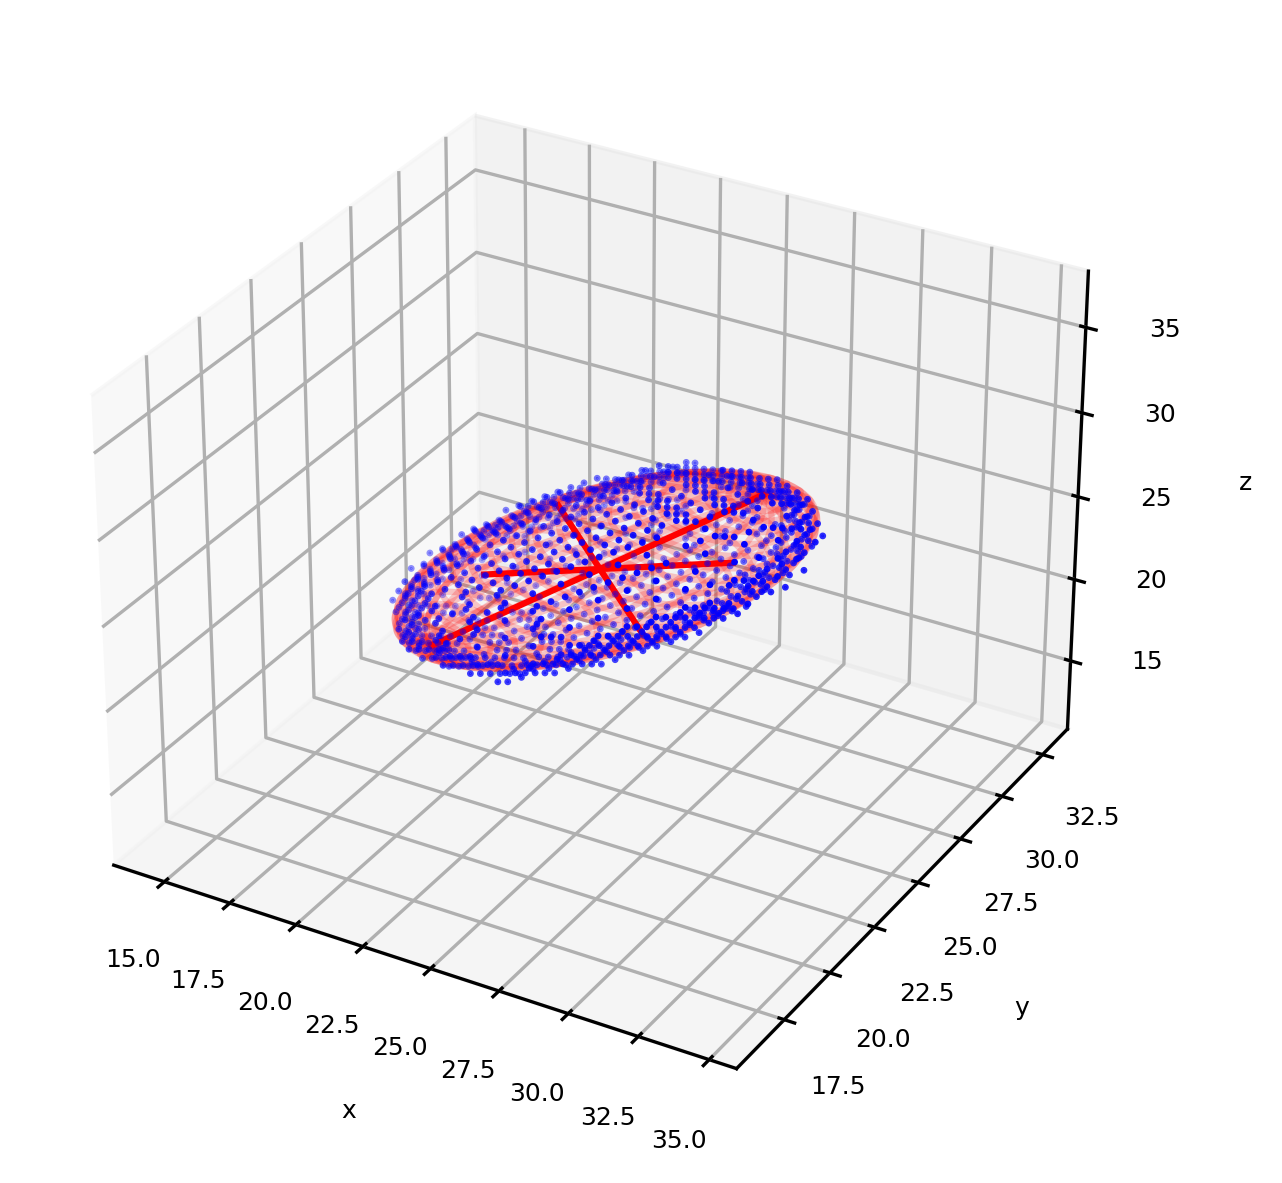

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coors[:,0], coors[:,1], coors[:,2], zdir='z', s=0.4, c='b',rasterized=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ef.ellipsoid_plot(center, radii, evecs, ax=ax, plot_axes=True, cage_color='red')
plt.show()

Ellipsoid eigenvalues

In [88]:
evals = 1 / (radii ** 2)

#### Degree of Anisotropy (DA) 
This is the ratio between the largest and smallest radii

In [89]:
DA = np.max(radii) / np.min(radii)
print(DA)

5.1276731911809925


#### Eigen-decomposition of fabric tensor
Compute the components of the symmetric Rank-2 fabric tensor T as:
$F = V A V^{T}$ \
Where $V$ is a 3x3 matrix of the ellipsoid eigenvectors, and $A$ is a diagonal matrix containing the ellipsoid eigenvalues on the diagonal term.

In [90]:
fabric_tens = np.matmul(evecs, np.matmul((evals * np.identity(3)), np.transpose(evecs)))

In [91]:
print(fabric_tens)

[[ 0.06307927 -0.02726832  0.02886669]
 [-0.02726832  0.05155509 -0.03008466]
 [ 0.02886669 -0.03008466  0.02620777]]


General `pyfabric` plot

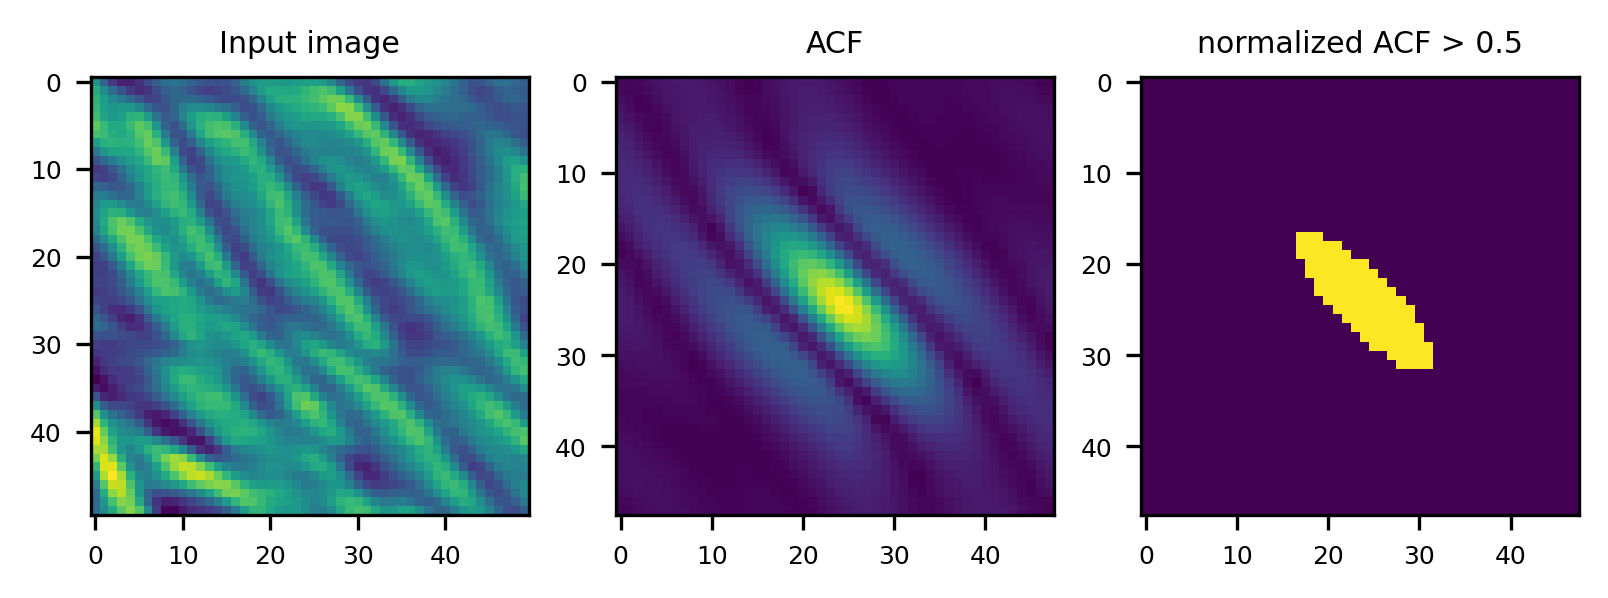

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.suptitle('Horizontally stacked subplots')
ax1.imshow(ROI[:, 25, :])
ax1.set_title('Input image')
ax2.imshow(ACFzoom[:, 25, :])
ax2.set_title('ACF')
ax3.imshow(ACFnorm[:, 25, :]>0.5)
ax3.set_title('normalized ACF > 0.5')
plt.show()